In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

tf.enable_eager_execution()
tf.set_random_seed(230)
print(tf.__version__)

import time
from matplotlib import pyplot as plt

/Documents/venv3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.11.0


In [71]:
hparams = tf.contrib.training.HParams(
    batch_size=100,
    in_seq_len=61,
    input_dim=5,
    out_seq_len=61,
    output_dim=1,
    num_layers=2,
    neurons_unit=32,
    learning_rate = 0.001,
    lr_decay = 0.99,
    lambd = 1e-6,
    train_split = 0.8,
    val_split = 0.1,
    test_split = 0.1,
    datagen = 'prodn',
    logs_path = '/tmp/tensorflow_logs')

### Define Data Generator

In [66]:
# Load production dataset
if hparams.datagen == 'prodn':
    prodn = pd.read_pickle('../full_6d.pkl').values
    dataset = np.nan_to_num(prodn)[2:130]
    mask = np.isfinite(prodn)[2:130]

# Load biogas dataset
if hparams.datagen == 'biogas':
    prodn = pd.read_csv('../Data/cr2c_opdata_TMP_PRESSURE_TEMP_WATER_COND_GAS_PH_DPI_LEVEL.csv')
    dataset = prodn['AT305'].values[:10000]
    dataset = [dataset[i : i + hparams.in_seq_len * hparams.input_dim + hparams.out_seq_len + 1] \
               for i in range(0, 10000 - hparams.in_seq_len * hparams.input_dim - hparams.out_seq_len)]
    dataset = np.nan_to_num(dataset)
    np.random.seed(230)
    np.random.shuffle(dataset)
    mask = np.isfinite(dataset)
    
# Create synthetic sine wave data
if hparams.datagen == 'sin':
    dataset = np.zeros((hparams.batch_size, 10 * hparams.in_seq_len))
    dataset[1:,0] = np.random.randn(hparams.batch_size-1)
    for i in range(dataset.shape[1] - 1):
        dataset[:,i+1] = dataset[:,i] + 2 * np.pi / hparams.in_seq_len
    dataset = np.sin(dataset) + 1
    mask = np.ones_like(dataset)

# Reshape data
in_len, out_len = hparams.in_seq_len, hparams.out_seq_len
end_pos = in_len * (hparams.input_dim - 1) + 1

# x.shape = (n_obs, in_seq_len, input_dim)
x_max, x_var = np.max(dataset[:,:end_pos], axis=1), np.var(dataset)
x_max[x_max==0] = x_max.max()
x_max = x_max.reshape(-1,1,1)
x = np.array([dataset[:,pos:pos+in_len] for pos in range(0,end_pos,hparams.in_seq_len)])
x = np.rollaxis(x, 0, 3) / x_max

y =   dataset[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis] / x_max
y_mask = mask[:,end_pos+in_len:end_pos+in_len+out_len, np.newaxis]

del(dataset, mask)
print(x.shape, y.shape, y_mask.shape)

(128, 61, 5) (128, 61, 1) (128, 61, 1)


In [67]:
train_pos = int(x.shape[0] * hparams.train_split)
val_pos   = int(x.shape[0] * (hparams.train_split + hparams.val_split))

dataset = tf.data.Dataset.from_tensor_slices(\
            (x[:train_pos].astype(np.float32),
             y[:train_pos].astype(np.float32),
             y_mask[:train_pos].astype(np.float32)))
dataset = dataset.batch(hparams.batch_size, drop_remainder=True)

dataset_val = tf.data.Dataset.from_tensor_slices(\
            (x[train_pos:val_pos].astype(np.float32),
             y[train_pos:val_pos].astype(np.float32),
             y_mask[train_pos:val_pos].astype(np.float32)))
dataset_val = dataset_val.batch(hparams.batch_size, drop_remainder=True)

dataset_test = tf.data.Dataset.from_tensor_slices(\
            (x[val_pos:].astype(np.float32),
             y[val_pos:].astype(np.float32),
             y_mask[val_pos:].astype(np.float32)))
dataset_test = dataset_val.batch(hparams.batch_size, drop_remainder=True)

### Define Model

In [5]:
def gru(units, name):
    # Use CuDNNGRU is GPU is available (provides a 3x speedup than GRU)
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                        return_sequences=True, 
                                        return_state=True, 
                                        recurrent_activation='relu',
                                        recurrent_initializer='glorot_uniform',
                                        name=name)
    else:
        return tf.keras.layers.GRU(units, 
                                   return_sequences=True, 
                                   return_state=True, 
                                   recurrent_activation='relu', 
                                   recurrent_initializer='glorot_uniform',
                                   name=name)

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Dense(units, activation='relu', name='encoder_affine_embedding')
        self.gru = gru(self.units, 'encoder_gru')
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='encoder_affine_out')
        
    def call(self, x, hidden):
        a = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        x = self.fc_out(output)

        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

In [7]:
class Decoder(tf.keras.Model):
    def __init__(self, output_dim, units, batch_size):
        super(Decoder, self).__init__()
        self.batch_size = batch_size
        self.units = units
        self.embedding = tf.keras.layers.Dense(units, activation='relu', name='decoder_affine_embedding')
        self.gru = gru(self.units, 'decoder_gru')
        self.fc_out = tf.keras.layers.Dense(output_dim, activation='relu', name='decoder_affine_out')
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.units, name='decoder_attn_W1')
        self.W2 = tf.keras.layers.Dense(self.units, name='decoder_attn_W2')
        self.V = tf.keras.layers.Dense(1, name='decoder_attn_V')
        
    def call(self, x, hidden, enc_output, mask):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        """output, state = self.gru(x, initial_state = hidden)"""
        
        # output shape == (batch_size * 1, hidden_size)
        """output = tf.reshape(output, (-1, output.shape[2]))"""
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc_out(output) * mask
        
        """return x, state, attention_weights"""
        return x, state
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_size, self.units))

### Train Model
loss_function: Build out MSE loss function with parameter regularisation

train_model: Runs the minibatch training loop

In [8]:
def loss_function(real, preds, variables, lambd = 0.0001):
    # Calculate OLS loss
    mse_loss = tf.losses.mean_squared_error(labels=real, predictions=preds)
    
    sum_mse_loss = tf.losses.mean_squared_error(tf.reduce_mean(real,  axis=(0,2)),
                                                tf.reduce_mean(preds, axis=(0,2)))

    # Add L2 Regularisation
    l2_loss = 0
    for var in variables:
        l2_loss += lambd * tf.reduce_sum(var ** 2)

    accuracy, loss = mse_loss, mse_loss + sum_mse_loss + l2_loss
    return loss, accuracy

In [68]:
def train_model(model, optimizer, dataset, hparams, epochs = 10, verbose = True):

    (encoder, decoder) = model
    training_run_start = time.time()
    stats = []

    for epoch in range(epochs):
        epoch_start = time.time()

        hidden = encoder.initialize_hidden_state()
        total_loss, total_accuracy = 0, 0

        for (batch, (inp, targ, mask)) in enumerate(dataset):
            loss, accuracy = 0, 0

            with tf.GradientTape() as tape:
                enc_output, enc_hidden = encoder(inp, hidden)

                dec_hidden = enc_hidden

                dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
                dec_input = tf.expand_dims(dec_input, 1)

                # Teacher forcing - feeding the target as the next input
                for t in range(1, targ.shape[1]):
                    # passing enc_output to the decoder
                    predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])

                    step_loss, step_accuracy = \
                        loss_function(targ[:, t:t+1], predictions, encoder.variables + decoder.variables)
                    loss += step_loss
                    accuracy += step_accuracy

                    # using teacher forcing - adapted to feed predictions
                    dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

            # update statistics
            batch_loss = (loss / int(targ.shape[1]))
            batch_accuracy = (accuracy / int(targ.shape[1]))

            total_loss += batch_loss
            total_accuracy += batch_accuracy

            # update gradients
            variables = encoder.variables + decoder.variables        
            gradients = tape.gradient(loss, variables)
            optimizer.apply_gradients(zip(gradients, variables))

        if verbose:
            print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                100 * total_loss / (batch+1), 100 * total_accuracy / (batch+1)))
            print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - epoch_start))
        
        # apply learning rate decay
        optimizer._lr *= hparams.lr_decay
        stats.append([total_loss / (batch+1), total_accuracy / (batch+1), time.time() - epoch_start])
    
    return total_loss / (batch+1), total_accuracy / (batch+1), time.time() - training_run_start, np.array(stats)

Run a training session and print training statistics and model structure

Epoch 1 Loss 23.1412 Accuracy 14.0836
Time taken for 1 epoch 4.0417 sec

Epoch 2 Loss 20.4455 Accuracy 12.3793
Time taken for 1 epoch 3.6213 sec

Epoch 3 Loss 17.9893 Accuracy 10.8334
Time taken for 1 epoch 3.3679 sec

Epoch 4 Loss 15.7765 Accuracy 9.4492
Time taken for 1 epoch 3.5894 sec

Epoch 5 Loss 13.8288 Accuracy 8.2335
Time taken for 1 epoch 3.4432 sec

Epoch 6 Loss 12.1500 Accuracy 7.1880
Time taken for 1 epoch 3.5680 sec

Epoch 7 Loss 10.7418 Accuracy 6.3132
Time taken for 1 epoch 3.3712 sec

Epoch 8 Loss 9.6040 Accuracy 5.6091
Time taken for 1 epoch 3.5876 sec

Epoch 9 Loss 8.7313 Accuracy 5.0722
Time taken for 1 epoch 3.6219 sec

Epoch 10 Loss 8.1124 Accuracy 4.6952
Time taken for 1 epoch 3.4634 sec

Loss 8.1124 Accuracy 4.6952 Time 35.6780


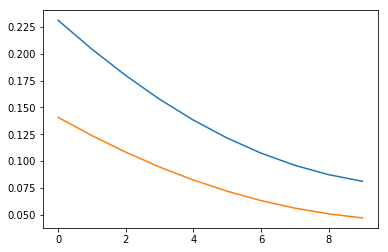

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_affine_embedding (De multiple                  192       
_________________________________________________________________
encoder_gru (GRU)            multiple                  3648      
_________________________________________________________________
encoder_affine_out (Dense)   multiple                  33        
Total params: 3,873
Trainable params: 3,873
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_affine_embedding (De multiple                  224       
_________________________________________________________________
decoder_gru (GRU)            multiple                  9312      
_________________________________________________________________
decoder_

In [70]:
# Run a training batch
tf.set_random_seed(231) # Set seed

# Initialise model and optimiser
encoder = Encoder(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
decoder = Decoder(hparams.output_dim, hparams.neurons_unit, hparams.batch_size)
optimizer = tf.train.AdamOptimizer(learning_rate = hparams.learning_rate)

# Start training run
loss, accuracy, run_time, stats = \
    train_model((encoder, decoder), optimizer, dataset, hparams, epochs=10, verbose=True)

# Display results
print('Loss {:.4f} Accuracy {:.4f} Time {:.4f}'.format(loss * 100, accuracy * 100, run_time))

plt.figure()
plt.plot(stats[:,:2])
plt.show()

encoder.summary()
decoder.summary()

In [11]:
model_accuracy = []

Total Accuracy: nan


/Documents/venv3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Documents/venv3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


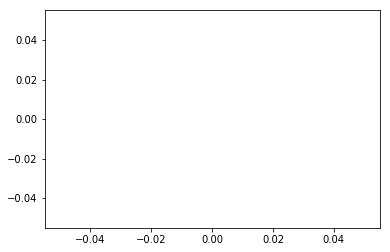

In [72]:
START_POINT = 0
total_accuracy = []

for i, (inp, target, mask) in enumerate(dataset_val):
    forecast = []

    hidden = encoder.initialize_hidden_state()
    enc_output, enc_hidden = encoder(inp[:, START_POINT:], hidden)

    dec_hidden = enc_hidden

    dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
    dec_input = tf.expand_dims(dec_input, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, target.shape[1]):
        # passing enc_output to the decoder
        predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
        forecast.append(np.squeeze(predictions))

        # using teacher forcing - adapted to feed predictions
        dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

    accuracy = (np.array(forecast).T - target[:,:60,0]) * x_max
    accuracy = accuracy ** 2 / x_var
    accuracy = np.mean(accuracy, axis=0)
    
    total_accuracy.append(accuracy)

model_accuracy.append((hparams.in_seq_len, np.mean(total_accuracy, axis=0)))
    
print('Total Accuracy: %.4f' % np.mean(total_accuracy))
plt.plot(np.mean(total_accuracy, axis=0))
plt.show()

[]

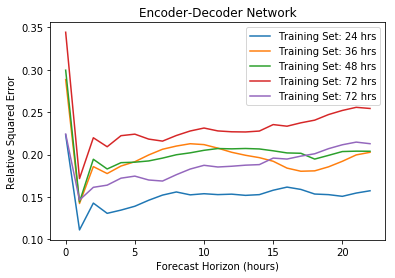

In [193]:
plt.figure()
for t, data in model_accuracy:
    plt.plot(data, label = 'Training Set: %i hrs' % t)
plt.legend()
plt.xlabel('Forecast Horizon (hours)')
plt.ylabel('Relative Squared Error')
plt.title('Encoder-Decoder Network')
plt.plot()

### Test Hyperparameters

In [ ]:
np.random.seed(231)
models, stats = [], []

lr    = np.log10(hparams.learning_rate)
nodes = hparams.neurons_unit

#for _ in range(25):
#   lr = np.random.uniform(-8, -1, 1):
#   nodes = np.floor(2 ** np.random.randint((3,9))):
#for nodes in np.floor(2 ** np.arange(3,9)):
for lr in range(-8, 0, 1):
    lr /= 2

    # Run a training batch
    tf.set_random_seed(231) # Set seed

    # Initialise model and optimiser
    encoder = Encoder(hparams.output_dim, int(nodes), hparams.batch_size)
    decoder = Decoder(hparams.output_dim, int(nodes), hparams.batch_size)
    optimizer = tf.train.AdamOptimizer(learning_rate = 10 ** lr)

    # Start training run
    loss, accuracy, run_time, stat = \
        train_model((encoder, decoder), optimizer, dataset, hparams, epochs = 5, verbose=False)
    print('Learning Rate {:.4f} Nodes {} Loss {:.4f} Accuracy {:.4f} Time {:.1f}'.format(\
                lr, nodes, loss*100, accuracy * 100, run_time))
    
    models.append((encoder,decoder))
    stats.append(stat)

### Make Predictions

In [13]:
# empty string to store our results
forecast = []

_, (inp, target, mask) = enumerate(dataset).__next__()

hidden = encoder.initialize_hidden_state()
enc_output, enc_hidden = encoder(inp[:, START_POINT:], hidden)

dec_hidden = enc_hidden

dec_input = tf.concat((inp[:,0,:], tf.expand_dims(inp[:,-1,-1], 1)), axis=1)
dec_input = tf.expand_dims(dec_input, 1)

# Teacher forcing - feeding the target as the next input
for t in range(1, target.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden = decoder(dec_input, dec_hidden, enc_output, mask[:,t:t+1])
    forecast.append(np.squeeze(predictions))

    _, _ = loss_function(target[:, t:t+1], predictions, encoder.variables + decoder.variables)

    # using teacher forcing - adapted to feed predictions
    dec_input = tf.concat((tf.expand_dims(inp[:,t,:],1), predictions), axis=2)

forecast = np.array(forecast)

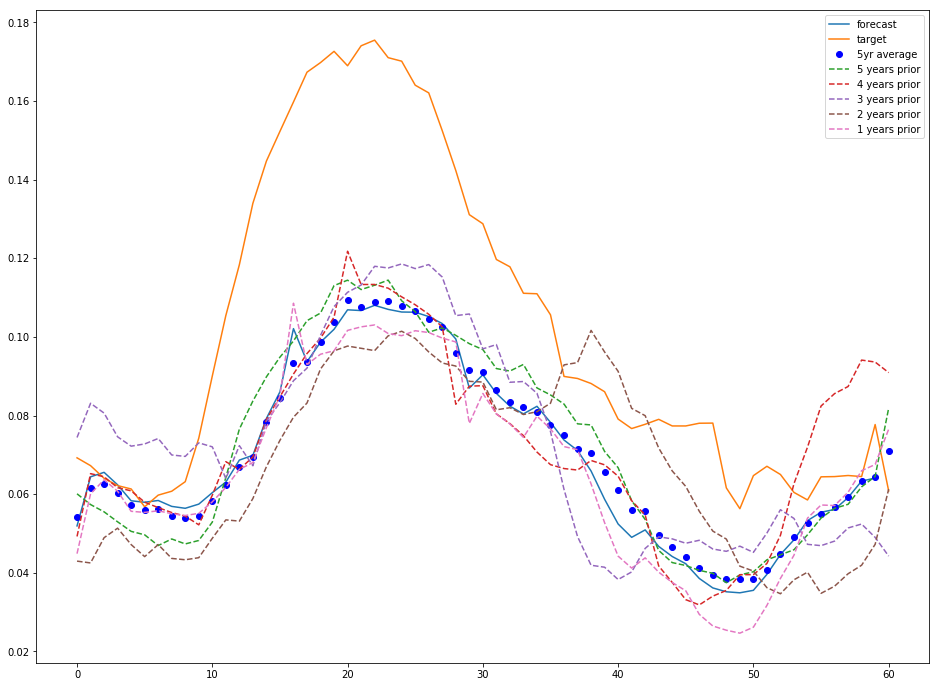

In [17]:
# empty string to store our results
TARGET_INDEX = 25
START_POINT = 0

# show target sequence
plt.figure(figsize=(16,12))
plt.plot(np.squeeze(forecast[:,TARGET_INDEX]), label='forecast')
plt.plot(np.squeeze(target[TARGET_INDEX]), label='target')
plt.plot(np.mean(inp, axis=2)[TARGET_INDEX], 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.array(inp)[TARGET_INDEX,:,i], '--', label='%i years prior' % (5-i))
plt.legend()
plt.show()

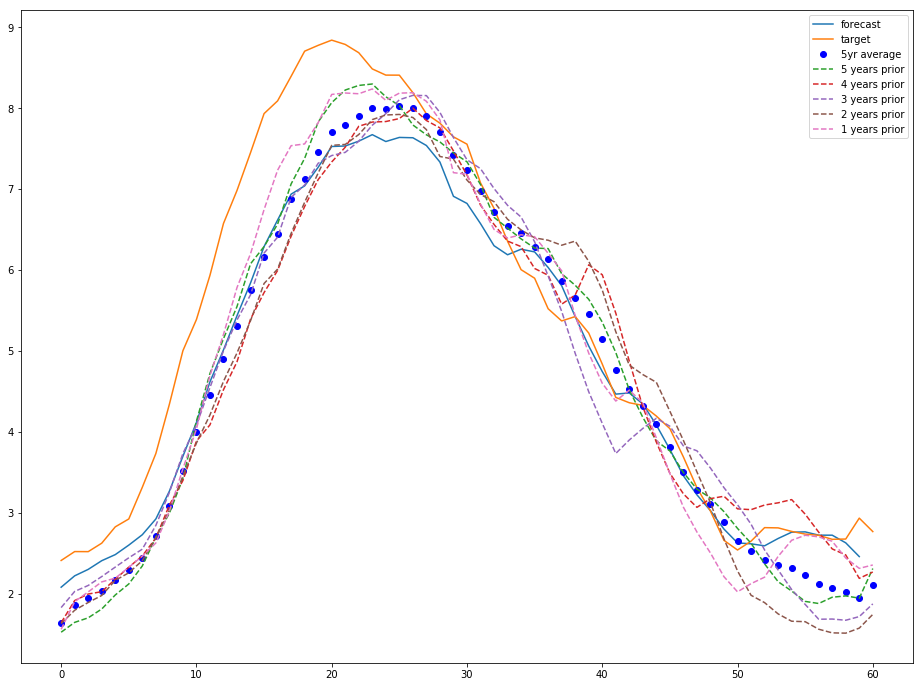

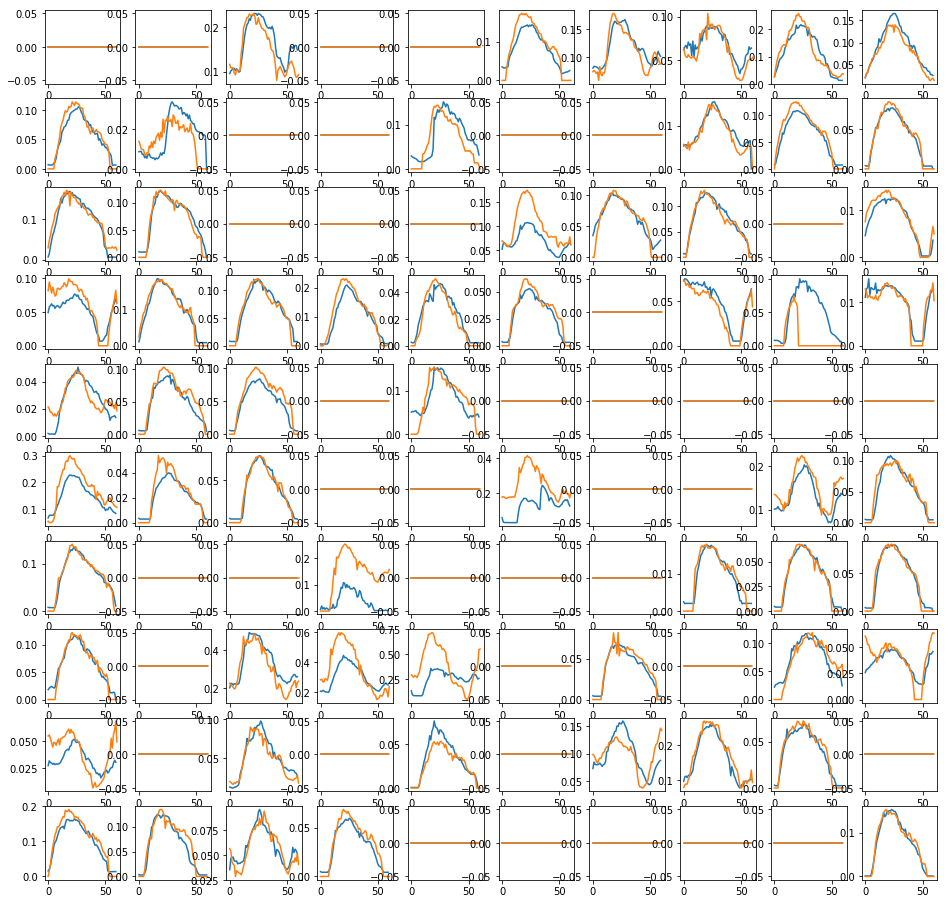

In [15]:
# show all sequences
plt.figure(figsize=(16,12))
plt.plot(np.sum(forecast, axis=1), label='forecast')
plt.plot(np.sum(target, axis=0), label='target')
plt.plot(np.sum(inp, axis=0).mean(axis=1), 'bo', label='5yr average')
for i in range(hparams.input_dim):
    plt.plot(np.sum(inp, axis=0)[:,i], '--', label='%i years prior' % (5-i))

plt.legend()
plt.show()

plt.figure(figsize=(16,16))
for i in range(0,100):
    ax = plt.subplot(10,10,i+1)
    ax.plot(np.squeeze(forecast[:,i]), label='forecast')
    ax.plot(np.squeeze(target[i]), label='target')
plt.show()

In [25]:
l_ = np.sum((forecast.T - np.squeeze(target)[:,:-1]) ** 2, axis=1)
l_.argsort()

array([ 0, 45, 46, 47, 48, 98, 53, 54, 56, 57, 61, 62, 64, 65, 66, 71, 75,
       77, 81, 83, 85, 89, 94, 95, 96, 97, 43, 36, 49, 23, 12, 15, 16, 22,
       28, 24, 13,  1,  3,  4, 67, 68, 34, 19, 52, 88, 69, 76, 35, 60, 27,
       82, 99, 92, 51, 11,  7, 93, 84, 37, 40, 32, 21, 10, 59, 70, 29, 41,
       91,  9, 18, 42, 31, 17, 79, 78, 39, 26,  6, 20, 80, 30, 87, 90, 86,
        2, 33, 58,  5,  8, 14, 44, 25, 38, 72, 50, 63, 73, 55, 74])

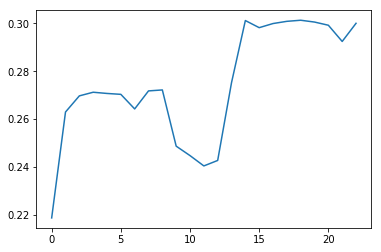

In [68]:
loss = np.mean((forecast.T*8.15 - target[:,1:,0]*8.15) ** 2 / dataset.var(), axis=0)
plt.plot(loss)
plt.show()

Adapted from examples contained in the official Tensorflow github repo;
<href>https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb</href>